In [1]:
import os, re, math, time, random, warnings, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# 이미 다운로드되었다면 이 셀은 생략해도 됩니다.
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
local_path = "/content/news_summary_more.csv"
if not os.path.exists(local_path):
    urllib.request.urlretrieve(url, filename=local_path)

data = pd.read_csv(local_path, encoding="iso-8859-1")
print("Columns:", list(data.columns))
data = data.copy()

# 안전한 컬럼 매핑
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"필요 컬럼을 찾을 수 없습니다: {candidates}")

text_col = pick_col(data, ['text', 'ctext', 'Text', 'article'])
sum_col  = pick_col(data, ['headlines', 'Summary', 'headline', 'abstract', 'title'])

data = data[[text_col, sum_col]].rename(columns={text_col:'text', sum_col:'summary'})
print(data.head(3))
print("샘플 수:", len(data))


Columns: ['headlines', 'text']
                                                text  \
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...   
1  Kunal Shah's credit card bill payment platform...   
2  New Zealand defeated India by 8 wickets in the...   

                                             summary  
0  upGrad learner switches to career in ML & Al w...  
1  Delhi techie wins free food from Swiggy for on...  
2  New Zealand end Rohit Sharma-led India's 12-ma...  
샘플 수: 98401


In [3]:
# strip & 결측 제거
data['text'] = data['text'].astype(str).str.strip()
data['summary'] = data['summary'].astype(str).str.strip()

before = len(data)
data.replace({'text': {'': np.nan}, 'summary': {'': np.nan}}, inplace=True)
data.dropna(subset=['text','summary'], inplace=True)
data.drop_duplicates(subset=['text'], inplace=True)
data.reset_index(drop=True, inplace=True)

print(f"결측/중복 제거: {before} → {len(data)}")
print("결측 현황:", data[['text','summary']].isnull().sum().to_dict())
data.sample(3)


결측/중복 제거: 98401 → 98345
결측 현황: {'text': 0, 'summary': 0}


,text,summary
575,The Income Tax Department has attached a porti...,I-T attaches some Mindtree shares held by Coff...
91626,Officers involved in the forced removal of a U...,"United flyer caused own injuries, police repor..."
48421,Cryptocurrency exchange Coindelta is celebrati...,Coindelta offers zero fee trading on bitcoin t...


In [4]:
# 영어 축약형(필요 최소)
contractions = {
    "can't":"cannot","won't":"will not","n't":" not","i'm":"i am","it's":"it is","'re":" are","'s":"",
    "'d":" would","'ll":" will","'ve":" have"
}
EN_STOPWORDS = set(stopwords.words('english'))

# 전처리 옵션
USE_CONTRACTION_MAP = True          # 영어 데이터에만 적용
REMOVE_STOPWORDS_TEXT = False       # 추상적 요약: 일반적으로 본문 불용어 제거 X 권장
REMOVE_STOPWORDS_SUM = False        # 요약은 더 짧으므로 보통 제거 X 권장


In [5]:
def normalize_english(s: str, remove_stop=False):
    s = s.lower()
    # HTML 제거(있을 때만)
    if "<" in s and ">" in s:
        s = BeautifulSoup(s, "lxml").text
    s = re.sub(r'\([^)]*\)', ' ', s)       # 괄호 안
    s = s.replace('"',' ')
    if USE_CONTRACTION_MAP:
        s = ' '.join([contractions.get(t,t) for t in s.split()])
    s = re.sub(r"[^a-z0-9]+", " ", s)      # 영문/숫자만
    s = re.sub(r'\s+', ' ', s).strip()

    if remove_stop:
        s = ' '.join([w for w in s.split() if w not in EN_STOPWORDS and len(w) > 1])
    else:
        s = ' '.join([w for w in s.split() if len(w) > 1])
    return s

# 점검
print(normalize_english("Everything I bought was great!! (really) It's AMAZING.", remove_stop=False))


everything bought was great it is amazing


In [6]:
from tqdm import tqdm
tqdm.pandas()

data['text_clean'] = data['text'].progress_apply(lambda x: normalize_english(x, REMOVE_STOPWORDS_TEXT))
data['summary_clean'] = data['summary'].progress_apply(lambda x: normalize_english(x, REMOVE_STOPWORDS_SUM))

# 공백/최소 길이 필터
MIN_TEXT_TOK, MIN_SUM_TOK = 8, 3
text_len = data['text_clean'].str.split().str.len()
sum_len  = data['summary_clean'].str.split().str.len()

mask = (text_len >= MIN_TEXT_TOK) & (sum_len >= MIN_SUM_TOK)
before = len(data); data = data[mask].drop_duplicates(subset=['text_clean']).reset_index(drop=True)
print(f"정제 후 길이 필터: {before} → {len(data)}")

# 길이 분포/퍼센타일
text_len = data['text_clean'].str.split().str.len().to_numpy()
sum_len  = data['summary_clean'].str.split().str.len().to_numpy()

stats = {
    "text_min": int(text_len.min()), "text_mean": float(text_len.mean()),
    "text_95p": int(np.percentile(text_len, 95)), "text_max": int(text_len.max()),
    "sum_min": int(sum_len.min()), "sum_mean": float(sum_len.mean()),
    "sum_95p": int(np.percentile(sum_len, 95)), "sum_max": int(sum_len.max()),
}
print("길이 통계:", stats)

# 패딩 최대 길이(상위 꼬리 자르기)
text_max_len     = min(150, max(50, stats["text_95p"]))   # 50~150 사이 자동
summary_max_len  = min(30,  max(8,  stats["sum_95p"]))    # 8~30 사이 자동
print("패딩 길이(text, summary):", text_max_len, summary_max_len)


100%|██████████| 98345/98345 [00:02<00:00, 43866.21it/s]


정제 후 길이 필터: 98345 → 98334
길이 통계: {'text_min': 34, 'text_mean': 57.34729595053593, 'text_95p': 61, 'text_max': 71, 'sum_min': 3, 'sum_mean': 9.546016637175342, 'sum_95p': 12, 'sum_max': 16}
패딩 길이(text, summary): 61 12


In [7]:
# SOS/EOS 추가(문장 자체에 토큰을 붙입니다)
data['decoder_input']  = 'sostoken ' + data['summary_clean']
data['decoder_target'] = data['summary_clean'] + ' eostoken'

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    data[['text_clean','decoder_input','decoder_target','summary_clean']],
    test_size=0.2, random_state=SEED, shuffle=True
)
len(train_df), len(val_df), train_df.head(2)


(78667,
 19667,
                                               text_clean  \
 89758  samajwadi party president akhilesh yadav has a...   
 38058  senior ips officer sudhesh kumar has been remo...   
 
                                            decoder_input  \
 89758  sostoken sp congress to fight 2019 ls polls in...   
 38058  sostoken kerala ips officer removed from post ...   
 
                                           decoder_target  \
 89758  sp congress to fight 2019 ls polls in alliance...   
 38058  kerala ips officer removed from post after dau...   
 
                                            summary_clean  
 89758  sp congress to fight 2019 ls polls in alliance...  
 38058  kerala ips officer removed from post after dau...  )

In [9]:
def simple_tokenizer(s: str):
    return s.split()

def build_vocab(texts, tokenizer, max_size=None, min_freq=1, specials=("<PAD>","<UNK>")):
    counter = Counter()
    for t in texts:
        counter.update(tokenizer(t))
    items = [(w,c) for w,c in counter.items() if c >= min_freq]
    # 빈도 내림차순, 동일빈도 사전순(재현성)
    items.sort(key=lambda x: (-x[1], x[0]))
    if max_size is not None:
        items = items[:max(0, max_size - len(specials))]
    word2idx = {tok:i for i, tok in enumerate(specials)}
    for w,_ in items:
        if w not in word2idx:
            word2idx[w] = len(word2idx)
    idx2word = {i:w for w,i in word2idx.items()}
    return word2idx, idx2word

# 하이퍼파라미터(어휘 크기/최소 빈도)
SRC_MAX_VOCAB = 30000
TGT_MAX_VOCAB = 15000
MIN_FREQ      = 2

src_word2idx, src_idx2word = build_vocab(
    train_df['text_clean'], simple_tokenizer, max_size=SRC_MAX_VOCAB, min_freq=MIN_FREQ,
    specials=("<PAD>","<UNK>")
)
tgt_word2idx, tgt_idx2word = build_vocab(
    list(train_df['decoder_input']) + list(train_df['decoder_target']),
    simple_tokenizer, max_size=TGT_MAX_VOCAB, min_freq=MIN_FREQ,
    specials=("<PAD>","<UNK>","sostoken","eostoken")
)

SRC_PAD = src_word2idx["<PAD>"]
TGT_PAD = tgt_word2idx["<PAD>"]
TGT_SOS = tgt_word2idx["sostoken"]
TGT_EOS = tgt_word2idx["eostoken"]

len(src_word2idx), len(tgt_word2idx), (SRC_PAD, TGT_PAD, TGT_SOS, TGT_EOS)


(30000, 14998, (0, 0, 2, 3))

In [10]:
def text_to_ids(texts, vocab, tokenizer):
    unk = vocab["<UNK>"]
    return [[vocab.get(w, unk) for w in tokenizer(t)] for t in texts]

def pad_sequences_pytorch(sequences, maxlen, pad_id):
    # list[list[int]] -> (B, T) LongTensor
    seq_tensors = [torch.tensor(seq[:maxlen], dtype=torch.long) for seq in sequences]
    if not seq_tensors:  # 빈 리스트 보호
        return torch.empty(0, maxlen, dtype=torch.long)
    padded = torch.nn.utils.rnn.pad_sequence(seq_tensors, batch_first=True, padding_value=pad_id)
    # 자르기 또는 패딩 추가
    if padded.size(1) < maxlen:
        pad_more = torch.full((padded.size(0), maxlen - padded.size(1)), pad_id, dtype=torch.long)
        padded = torch.cat([padded, pad_more], dim=1)
    return padded[:, :maxlen]

# 시퀀스 구성
enc_train_ids = text_to_ids(train_df['text_clean'], src_word2idx, simple_tokenizer)
enc_val_ids   = text_to_ids(val_df['text_clean'],   src_word2idx, simple_tokenizer)

decin_train_ids  = text_to_ids(train_df['decoder_input'],  tgt_word2idx, simple_tokenizer)
dectg_train_ids  = text_to_ids(train_df['decoder_target'], tgt_word2idx, simple_tokenizer)
decin_val_ids    = text_to_ids(val_df['decoder_input'],    tgt_word2idx, simple_tokenizer)
dectg_val_ids    = text_to_ids(val_df['decoder_target'],   tgt_word2idx, simple_tokenizer)

decoder_max_len = summary_max_len + 2  # SOS/EOS 포함

# 패딩
enc_tr = pad_sequences_pytorch(enc_train_ids, text_max_len, SRC_PAD)
enc_va = pad_sequences_pytorch(enc_val_ids,   text_max_len, SRC_PAD)
din_tr = pad_sequences_pytorch(decin_train_ids,  decoder_max_len, TGT_PAD)
dtg_tr = pad_sequences_pytorch(dectg_train_ids,  decoder_max_len, TGT_PAD)
din_va = pad_sequences_pytorch(decin_val_ids,    decoder_max_len, TGT_PAD)
dtg_va = pad_sequences_pytorch(dectg_val_ids,    decoder_max_len, TGT_PAD)

enc_tr.shape, din_tr.shape, dtg_tr.shape, enc_va.shape


(torch.Size([78667, 61]),
 torch.Size([78667, 14]),
 torch.Size([78667, 14]),
 torch.Size([19667, 61]))

In [11]:
BATCH_SIZE = 128

train_dataset = TensorDataset(enc_tr, din_tr, dtg_tr)
val_dataset   = TensorDataset(enc_va, din_va, dtg_va)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 615 val batches: 154


In [14]:
embedding_dim = 128
hidden_size   = 256
src_vocab_size = len(src_word2idx)
tgt_vocab_size = len(tgt_word2idx)

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=3, dropout=0.4, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
    def forward(self, x):
        emb = self.embedding(x)  # (B,T,E)
        out, (h,c) = self.lstm(emb)  # out: (B,T,H)
        return out, h, c

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=3, dropout=0.4, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
    def forward(self, y_in, h, c):
        emb = self.embedding(y_in)           # (B,T,E)
        out, (h,c) = self.lstm(emb, (h,c))   # out: (B,T,H)
        return out, h, c

class AttentionDot(nn.Module):
    def forward(self, dec_out, enc_out, src_mask=None):
        # dec_out: (B,T_tgt,H), enc_out: (B,T_src,H)
        scores = torch.bmm(dec_out, enc_out.transpose(1, 2))  # (B,T_tgt,T_src)
        if src_mask is not None:
            mask = ~src_mask.unsqueeze(1)                     # (B,1,T_src) False=PAD
            neg = torch.finfo(scores.dtype).min               # half에서도 안전한 최소값(≈ -6.55e4)
            scores = scores.masked_fill(mask, neg)
            # 대안: neg = scores.new_full((), -1e4)  # 이렇게 고정 상수로도 충분합니다.
        attn = torch.softmax(scores, dim=-1)
        ctx  = torch.bmm(attn, enc_out)                       # (B,T_tgt,H)
        return ctx, attn

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, hidden_size, vocab_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attn    = AttentionDot()
        self.fuse    = nn.Linear(hidden_size*2, hidden_size)
        self.out     = nn.Linear(hidden_size, vocab_size)
    def forward(self, src, y_in, src_pad_id):
        enc_out, h, c = self.encoder(src)                # (B,Tsrc,H)
        src_mask = (src != src_pad_id)                   # (B,Tsrc)
        dec_out, h, c = self.decoder(y_in, h, c)         # (B,Ttgt,H)
        ctx, attn_w = self.attn(dec_out, enc_out, src_mask)     # (B,Ttgt,H)
        fused = torch.tanh(self.fuse(torch.cat([dec_out, ctx], dim=-1)))  # (B,Ttgt,H)
        logits = self.out(fused)                         # (B,Ttgt,V)
        return logits, attn_w

encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4, padding_idx=SRC_PAD).to(device)
decoder = Decoder(tgt_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4, padding_idx=TGT_PAD).to(device)
model   = Seq2SeqWithAttention(encoder, decoder, hidden_size, tgt_vocab_size).to(device)

sum(p.numel() for p in model.parameters())/1e6, model.__class__.__name__


(12.64143, 'Seq2SeqWithAttention')

In [15]:
EPOCHS = 50
LR     = 1e-3
PATIENCE = 3

criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, steps = 0.0, 0
    for src, y_in, y_tg in loader:
        src = src.to(device); y_in = y_in.to(device); y_tg = y_tg.to(device)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits, _ = model(src, y_in, SRC_PAD)                 # (B,T,V)
            V = logits.size(-1)
            loss = criterion(logits.reshape(-1, V), y_tg.reshape(-1))
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
        total += loss.item(); steps += 1
    return total / max(steps,1)

best_val = float('inf'); no_improve = 0
train_losses, val_losses = [], []
ckpt_path = "/content/best_seq2seq.pt"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader,   False)
    scheduler.step(va)
    train_losses.append(tr); val_losses.append(va)
    flag = ""
    if va < best_val:
        best_val = va; no_improve = 0; flag = "✓"
        torch.save({
            "model": model.state_dict(),
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict(),
            "src_vocab": src_word2idx,
            "tgt_vocab": tgt_word2idx,
            "text_max_len": text_max_len,
            "summary_max_len": summary_max_len
        }, ckpt_path)
    else:
        no_improve += 1
    dt = time.time()-t0
    print(f"[{epoch:02d}] train {tr:.4f} | val {va:.4f} | lr {optimizer.param_groups[0]['lr']:.2e} | {dt:.1f}s {flag}")
    if no_improve >= PATIENCE:
        print("Early stopping.")
        break

print("Best ckpt:", ckpt_path)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-1397676556.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1397676556.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[01] train 7.2200 | val 6.9636 | lr 1.00e-03 | 19.9s ✓
[02] train 6.9465 | val 6.7940 | lr 1.00e-03 | 18.6s ✓
[03] train 6.7954 | val 6.6631 | lr 1.00e-03 | 19.3s ✓
[04] train 6.6095 | val 6.4885 | lr 1.00e-03 | 18.6s ✓
[05] train 6.4664 | val 6.3722 | lr 1.00e-03 | 18.7s ✓
[06] train 6.3312 | val 6.2441 | lr 1.00e-03 | 18.6s ✓
[07] train 6.2012 | val 6.1413 | lr 1.00e-03 | 19.0s ✓
[08] train 6.1100 | val 6.0801 | lr 1.00e-03 | 18.6s ✓
[09] train 6.0434 | val 6.0255 | lr 1.00e-03 | 19.3s ✓
[10] train 5.9769 | val 5.9580 | lr 1.00e-03 | 18.3s ✓
[11] train 5.9168 | val 5.9265 | lr 1.00e-03 | 18.6s ✓
[12] train 5.8840 | val 5.8990 | lr 1.00e-03 | 18.2s ✓
[13] train 5.8518 | val 5.8722 | lr 1.00e-03 | 18.6s ✓
[14] train 5.8214 | val 5.8452 | lr 1.00e-03 | 18.2s ✓
[15] train 5.7922 | val 5.8222 | lr 1.00e-03 | 18.7s ✓
[16] train 5.7652 | val 5.7965 | lr 1.00e-03 | 18.2s ✓
[17] train 5.7450 | val 5.7768 | lr 1.00e-03 | 18.6s ✓
[18] train 5.7127 | val 5.7441 | lr 1.00e-03 | 18.1s ✓
[19] train

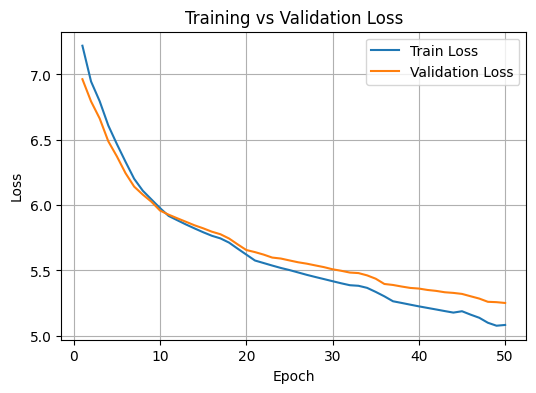

In [16]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.show()


In [17]:
src_idx2word = src_idx2word
tgt_idx2word = tgt_idx2word

def seq2text(ids):
    toks = [src_idx2word.get(int(i), "<UNK>") for i in ids if int(i) != SRC_PAD]
    return " ".join(toks)

def ids_to_summary(ids):
    out = []
    for i in ids:
        i = int(i)
        w = tgt_idx2word.get(i, "<UNK>")
        if w in ("sostoken","<PAD>"): continue
        if w == "eostoken": break
        out.append(w)
    return " ".join(out)

@torch.no_grad()
def greedy_decode(model, src_seq, max_len=None):
    model.eval()
    if src_seq.dim() == 1:
        src = src_seq.unsqueeze(0)
    else:
        src = src_seq
    src = src.to(device)

    enc_out, h, c = model.encoder(src)
    src_mask = (src != SRC_PAD)

    y = torch.full((src.size(0), 1), TGT_SOS, dtype=torch.long, device=device)  # (B,1)
    max_len = max_len or (summary_max_len + 2)

    decoded = [[] for _ in range(src.size(0))]
    finished = torch.zeros(src.size(0), dtype=torch.bool, device=device)

    for _ in range(max_len):
        emb = model.decoder.embedding(y[:, -1:])
        dec_step, (h, c) = model.decoder.lstm(emb, (h, c)) # (B,1,H)
        ctx, _ = model.attn(dec_step, enc_out, src_mask)   # (B,1,H)
        fused = torch.tanh(model.fuse(torch.cat([dec_step, ctx], dim=-1)))  # (B,1,H)
        logits = model.out(fused).squeeze(1)               # (B,V)
        next_tok = torch.argmax(logits, dim=-1)            # (B,)
        for i in range(src.size(0)):
            if not finished[i]:
                tid = int(next_tok[i].item())
                decoded[i].append(tid)
                if tid == TGT_EOS:
                    finished[i] = True
        if finished.all(): break
        y = torch.cat([y, next_tok.unsqueeze(1)], dim=1)

    return [" ".join([tgt_idx2word.get(t,"<UNK>") for t in seq]) for seq in decoded]

# 샘플 확인
i = 0
print("SRC:", seq2text(enc_va[i].cpu().numpy()))
pred = greedy_decode(model, enc_va[i])
print("PRED:", ids_to_summary([tgt_word2idx.get(w, TGT_PAD) for w in pred[0].split()]))
print("REF :", val_df.iloc[i]['summary_clean'])


SRC: pnb on monday said customers money was safe and also assured that they could withdraw or deposit their money anytime with strong balance sheet of 11 trillion and sufficient non core assets pnb said it is capable to meet any contingent liability on the bank on billion fraud pnb said it has zero tolerance to unethical practices within the system
PRED: pnb of <UNK> to stop <UNK> of <UNK> <UNK>
REF : your money is safe with us pnb to customers


In [19]:
# Java 17 설치 (조용히)
!apt-get -y install openjdk-17-jre-headless > /dev/null

import os, subprocess, sys
java_home = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = java_home
os.environ['PATH'] = f"{java_home}/bin:" + os.environ.get('PATH', '')

# 확인
!java -version
print("JAVA_HOME:", os.environ['JAVA_HOME'])


openjdk version "17.0.15" 2025-04-15
OpenJDK Runtime Environment (build 17.0.15+6-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 17.0.15+6-Ubuntu-0ubuntu122.04, mixed mode, sharing)
JAVA_HOME: /usr/lib/jvm/java-17-openjdk-amd64


In [20]:
# ROUGE
!pip -q install rouge-score language-tool-python textstat

import numpy as np
from rouge_score import rouge_scorer
import language_tool_python
import textstat

def compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeLsum'], use_stemmer=True)
    r1=r2=rl=0.0
    for p,r in zip(preds, refs):
        s = scorer.score(r, p)
        r1 += s['rouge1'].fmeasure
        r2 += s['rouge2'].fmeasure
        rl += s['rougeLsum'].fmeasure
    n = max(1, len(preds))
    return {"rouge1": r1/n, "rouge2": r2/n, "rougeL": rl/n}

# 핵심단어 포함률(참고: 참조 요약에서 불용어·숫자 제거 후 unique 키워드 대비 예측문 등장 비율)
def keyword_coverage(pred, ref, stop=EN_STOPWORDS):
    toks_ref = [w for w in ref.split() if w not in stop and w.isalpha()]
    kws = set(toks_ref)
    if not kws: return 0.0
    toks_pred = set([w for w in pred.split()])
    covered = len(kws & toks_pred) / len(kws)
    return covered

# 문법 완성도: LanguageTool 오류 밀도(오류 수 / 토큰수), 낮을수록 좋음
tool = language_tool_python.LanguageTool('en-US')

def grammar_error_density(text):
    if not text.strip():
        return 1.0
    matches = tool.check(text)
    tok_cnt = max(1, len(text.split()))
    return len(matches) / tok_cnt

# 배치 평가
M = min(500, len(enc_va))
pred_strs = []
ref_strs  = []
for i in range(M):
    pred_raw = greedy_decode(model, enc_va[i])[0]
    pred = ids_to_summary([tgt_word2idx.get(w, TGT_PAD) for w in pred_raw.split()])
    ref  = val_df.iloc[i]['summary_clean']
    pred_strs.append(pred)
    ref_strs.append(ref)

rouge = compute_rouge(pred_strs, ref_strs)
print("ROUGE(F1):", {k: round(v,4) for k,v in rouge.items()})

# 표: 문법 완성도 & 핵심단어 포함률 (평균)
gram_pred = np.mean([grammar_error_density(p) for p in pred_strs])
gram_ref  = np.mean([grammar_error_density(r) for r in ref_strs])
cov_pred  = np.mean([keyword_coverage(p, r) for p,r in zip(pred_strs, ref_strs)])
cov_ref   = np.mean([keyword_coverage(r, r) for r in ref_strs])  # 참조 스스로 기준 → 1.0

summary_table = pd.DataFrame({
    "항목": ["문법 오류 밀도(↓)", "핵심단어 포함률(↑)"],
    "예측 요약": [round(gram_pred,4), round(cov_pred,4)],
    "실제 요약": [round(gram_ref,4),  round(cov_ref,4)]
})
summary_table


INFO:language_tool_python.download_lt:Unzipping /tmp/tmpul56q9i1.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip to /root/.cache/language_tool_python.


ROUGE(F1): {'rouge1': 0.1712, 'rouge2': 0.0265, 'rougeL': 0.1584}


,항목,예측 요약,실제 요약
0,문법 오류 밀도(↓),0.1870,0.2571
1,핵심단어 포함률(↑),0.1198,1.0000


In [21]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeLsum'], use_stemmer=True)

rows = []
K = min(20, M)  # 표로 20개만 표시
for i in range(K):
    p, r = pred_strs[i], ref_strs[i]
    s = scorer.score(r, p)
    rows.append({
        "idx": i,
        "예측 요약": p,
        "실제 요약": r,
        "문법오류밀도(예측)": round(grammar_error_density(p),4),
        "핵심단어포함률(예측)": round(keyword_coverage(p, r),4),
        "ROUGE-1": round(s['rouge1'].fmeasure,4),
        "ROUGE-2": round(s['rouge2'].fmeasure,4),
        "ROUGE-L": round(s['rougeLsum'].fmeasure,4),
    })

sample_eval = pd.DataFrame(rows)
sample_eval


,idx,예측 요약,실제 요약,문법오류밀도(예측),핵심단어포함률(예측),ROUGE-1,ROUGE-2,ROUGE-L
0,0,pnb of <UNK> to stop <UNK> of <UNK> <UNK>,your money is safe with us pnb to customers,0.1111,0.2000,0.2222,0.0000,0.2222
1,1,cbi files woman to <UNK> her sex to be <UNK>,taiwan woman granted divorce as husband ignore...,0.1000,0.1429,0.2105,0.0000,0.2105
2,2,govt to get <UNK> <UNK> on <UNK> <UNK>,imported mobile phone prices to rise with 10 c...,0.1250,0.0000,0.1111,0.0000,0.1111
3,3,bengaluru based startup <UNK> raises million,service provider easygov backed by tata trust ...,0.3333,0.0000,0.0000,0.0000,0.0000
4,4,bjp leader son <UNK> <UNK> in delhi cm kejriwal,bjp files complaint against karnataka cm over ...,0.3333,0.2857,0.2222,0.0000,0.2222
5,5,<UNK> of <UNK> to death in <UNK> <UNK>,patients tied to beds at amu medical college,0.0000,0.0000,0.1250,0.0000,0.1250
6,6,police <UNK> <UNK> to be <UNK> to <UNK> <UNK>,mp civic body turns garbage truck into van for...,0.1111,0.0000,0.0000,0.0000,0.0000
7,7,srk khan shares pic with his son with him in h...,shah rukh abram greet fans on the occasion of eid,0.0833,0.0000,0.0000,0.0000,0.0000
8,8,<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK...,india top ranked shot putter manpreet suspende...,0.0000,0.0000,0.0000,0.0000,0.0000
9,9,us to launch <UNK> for <UNK> to <UNK> <UNK>,us plans to end work permits for 1b visa holde...,0.1111,0.1250,0.3000,0.0000,0.3000


from matplotlib import pyplot as plt
sample_eval['idx'].plot(kind='hist', bins=20, title='idx')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval['문법오류밀도(예측)'].plot(kind='hist', bins=20, title='문법오류밀도(예측)')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval['핵심단어포함률(예측)'].plot(kind='hist', bins=20, title='핵심단어포함률(예측)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sample_eval['ROUGE-1'].plot(kind='hist', bins=20, title='ROUGE-1')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval.plot(kind='scatter', x='idx', y='문법오류밀도(예측)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval.plot(kind='scatter', x='문법오류밀도(예측)', y='핵심단어포함률(예측)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval.plot(kind='scatter', x='핵심단어포함률(예측)', y='ROUGE-1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sample_eval.plot(kind='scatter', x='ROUGE-1', y='ROUGE-2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['idx']
  ys = series['문법오류밀도(예측)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sample_eval.sort_values('idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('문법오류밀도(예측)')

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['idx']
  ys = series['핵심단어포함률(예측)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sample_eval.sort_values('idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('핵심단어포함률(예측)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['idx']
  ys = series['ROUGE-1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sample_eval.sort_values('idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('ROUGE-1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['idx']
  ys = series['ROUGE-2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sample_eval.sort_values('idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('idx')
_ = plt.ylabel('ROUGE-2')

from matplotlib import pyplot as plt
sample_eval['idx'].plot(kind='line', figsize=(8, 4), title='idx')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval['문법오류밀도(예측)'].plot(kind='line', figsize=(8, 4), title='문법오류밀도(예측)')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE 

from matplotlib import pyplot as plt
sample_eval['핵심단어포함률(예측)'].plot(kind='line', figsize=(8, 4), title='핵심단어포함률(예측)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
sample_eval['ROUGE-1'].plot(kind='line', figsize=(8, 4), title='ROUGE-1')
plt.gca().spines[['top', 'right']].set_visible(False)

## 회고

본 노트북에서는 뉴스 기사 본문을 요약하는 Seq2Seq 모델을 구축하고 학습함.

**진행 과정:**

1.  **데이터 로딩 및 전처리:** 뉴스 요약 데이터셋을 불러와 텍스트 정제(HTML, 괄호 제거, 소문자 변환, 축약형 확장 등), 결측치 및 중복 제거를 수행
2.  **데이터 준비:** 전처리된 데이터를 바탕으로 소스(본문)와 타겟(요약) 시퀀스를 구성하고, 어휘집을 구축하여 텍스트를 정수 시퀀스로 변환. 패딩 작업을 통해 시퀀스 길이를 맞추고 학습 및 검증 데이터셋을 생성.
3.  **모델 구축 및 학습:** 어텐션 메커니즘이 적용된 Seq2Seq 모델(Encoder-Decoder LSTM)을 정의하고 학습을 진행.
4.  **평가:** 학습된 모델을 사용하여 요약을 생성하고, ROUGE 스코어, 문법 오류 밀도, 핵심 단어 포함률 등의 지표로 성능을 평가.

**결과 분석:**

학습 손실은 꾸준히 감소했지만, 검증 손실과의 차이가 크지 않아 과적합 징후는 뚜렷하지 않았습니다. 그러나 최종 ROUGE 스코어가 낮고, 샘플 예측 요약에 `<UNK>` 토큰이 빈번하게 나타났으며, 문법 오류 밀도가 실제 요약보다 높은 결과를 보였습니다. 이는 모델이 원문의 내용을 제대로 파악하고 자연스러운 요약을 생성하는 데 어려움을 겪고 있음을 시사합니다. 핵심 단어 포함률 또한 낮아 원문의 중요한 정보를 요약에 담아내지 못하는 경향을 보였습니다.

**개선 방안:**

현재 모델의 성능이 만족스럽지 않은 주된 이유는 다음과 같을 수 있습니다.

*   **모델 복잡성:** 기본적인 Seq2Seq + Attention 모델은 최신 Transformer 기반 모델(BERT, GPT 등)에 비해 복잡한 언어 패턴 학습 능력이 떨어질 수 있습니다. 더 발전된 모델 아키텍처를 고려해 볼 수 있습니다.
*   **하이퍼파라미터 최적화:** 학습률, 배치 크기, 에포크 수, 드롭아웃 등 다양한 하이퍼파라미터를 체계적으로 튜닝하여 모델 성능을 극대화할 필요가 있습니다.
*   **어휘 크기 및 처리:** `<UNK>` 토큰 비율을 줄이기 위해 어휘 크기를 늘리거나, OOV(Out-Of-Vocabulary) 단어를 처리하는 방식을 개선할 수 있습니다.
*   **데이터셋:** 데이터셋의 크기를 늘리거나, 데이터 정제 및 전처리 방식을 더욱 정교하게 할 수 있습니다.

다음 단계로는 모델 아키텍처를 변경하거나, 하이퍼파라미터 튜닝을 수행하거나, 데이터 전처리 방식을 개선하는 등의 실험을 통해 요약 성능을 향상시키는 것을 고려해 볼 수 있습니다.